In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_poisson_deviance
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split

import matplotlib.pyplot as plt

df = pd.read_csv('data/daily_fixed_nulls.csv')
df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

lst = ['city_destination', 'observation_date', 'delivery_date','observation_date_y','observation_date_w', 
         'observation_date_d','delivery_date_y', 'delivery_date_w', 'delivery_date_d',
         'total_booked_cancelation_prediction','lead_time']

ml_df = df.drop(lst, axis = 1)
ml_df = ml_df.dropna()

In [2]:
ml_df.head()

,exp_mov_avg3,exp_mov_avg4,exp_mov_avg5,exp_mov_avg6,exp_mov_avg7,target_demanded
0,1.0,1.0,1.0,1.0,1.0,1.0
1,27.0,35.0,44.0,52.0,63.0,40.0
2,1.0,2.0,2.0,2.0,3.0,1.0
3,9.0,12.0,15.0,18.0,21.0,14.0
4,0.0,0.0,0.0,0.0,0.0,0.0


Root Mean Squared Error: 11.186432842572218
Mean Absolute Error: 4.306665480366474
Mean Poisson Deviance Error: 2.551353970511708
R-squared: 0.9634058085219344


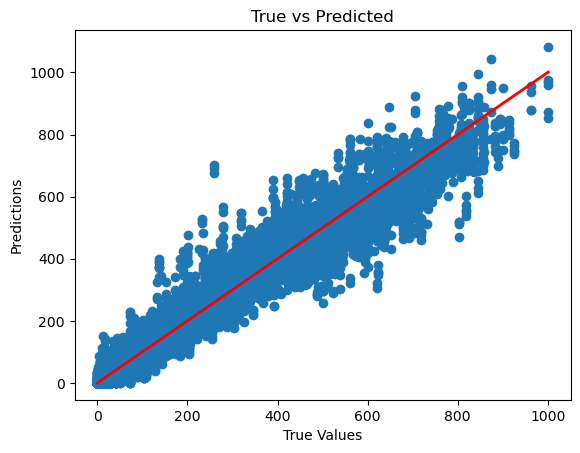

In [3]:
X = ml_df.drop(columns=['target_demanded']) 
y = ml_df['target_demanded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train_ = sc.fit_transform(X_train)
X_test_ = sc.transform(X_test)

model = LinearRegression()
model.fit(X_train_, y_train)

y_pred = abs(model.predict(X_test_))

rmse = root_mean_squared_error(y_test, y_pred)
mae =  mean_absolute_error(y_test, y_pred)
mpde = mean_poisson_deviance(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Poisson Deviance Error: {mpde}")
print(f"R-squared: {r2}")

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.show()

In [4]:
feature_names = X.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Intercept': model.intercept_,
    'Coef': model.coef_
})

print(coef_df)

        Feature  Intercept       Coef
0  exp_mov_avg3  18.216854  13.309141
1  exp_mov_avg4  18.216854  19.416401
2  exp_mov_avg5  18.216854  29.786063
3  exp_mov_avg6  18.216854 -58.359269
4  exp_mov_avg7  18.216854  53.526610


<Figure size 1000x600 with 0 Axes>

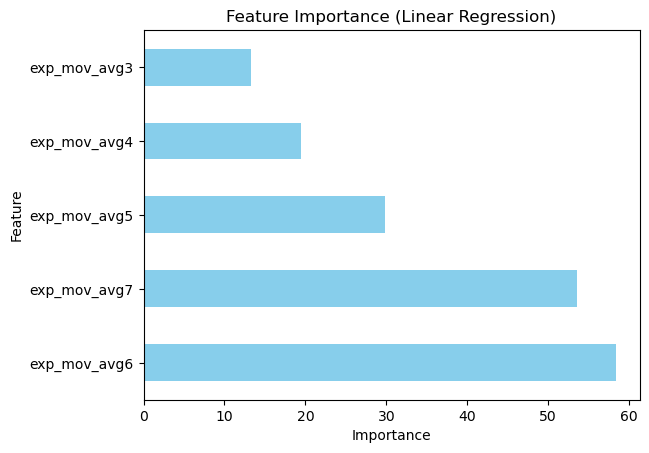

In [5]:
feature_importance = abs(model.coef_)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, color='skyblue')
plt.title('Feature Importance (Linear Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [6]:
cv_scores = cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error')

cv_scores = -cv_scores  
mean_cv_score = np.mean(cv_scores)

print(f"Cross-validated Mean Squared Error (MSE): {mean_cv_score:.4f}")
print(f"Individual Fold Scores (MSE): {cv_scores}")

Cross-validated Mean Squared Error (MSE): 11.2872
Individual Fold Scores (MSE): [12.15789924 10.24152173 10.48523288 11.23715662 10.28072221 12.40605977
 11.68376124 11.6302921  11.73838191 11.01061701]


In [7]:
model = LinearRegression()

coefficients = []

rmse_scores = []
mae_scores = []

tscv = TimeSeriesSplit(n_splits=10)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    coefficients.append(model.coef_)
    
    y_pred = model.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores.append(rmse)
    
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

coefficients_df = pd.DataFrame(coefficients, columns=X.columns)

average_rmse = np.mean(rmse_scores)
average_mae = np.mean(mae_scores)

print(f"Average RMSE across all folds: {average_rmse:.4f}")
print(f"Average MAE across all folds: {average_mae:.4f}")

print("Coefficients for each fold:")
print(coefficients_df)

Average RMSE across all folds: 11.1929
Average MAE across all folds: 4.3204
Coefficients for each fold:
   exp_mov_avg3  exp_mov_avg4  exp_mov_avg5  exp_mov_avg6  exp_mov_avg7
0      1.111623      0.352414     -0.335487     -0.177951      0.330702
1      0.773888      0.710981      0.118307     -0.781653      0.464521
2      0.820553      0.470485      0.048389     -0.480651      0.369906
3      0.739649      0.467153      0.159036     -0.513278      0.358897
4      0.652588      0.489191      0.250185     -0.568237      0.362986
5      0.617161      0.454997      0.223194     -0.493706      0.347096
6      0.563880      0.455988      0.249408     -0.464034      0.327312
7      0.574640      0.426840      0.301945     -0.499772      0.331485
8      0.468280      0.500641      0.395468     -0.598589      0.349921
9      0.430268      0.498771      0.480240     -0.665837      0.362711


Root Mean Squared Error: 13.417654879808694
Mean Absolute Error: 5.2609268296198
Mean Poisson Deviance Error: 4.05024673440786
R-squared: 0.9473519668969227


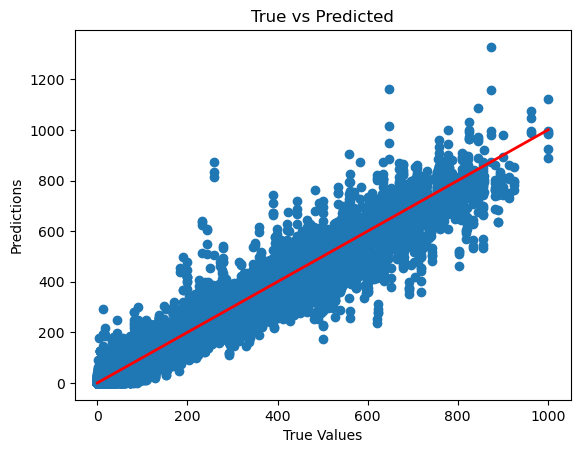

In [8]:
#Comparison with the Linear Regression trained on total_booked_cancellation_prediction

ml_df2 = df.copy()

X_actual = ml_df2[['total_booked_cancelation_prediction']]
y_actual = ml_df2['target_demanded']  

X_train_actual, X_test_actual, y_train_actual, y_test_actual = train_test_split(X_actual, y_actual, test_size=0.2, random_state=42)


sc_act = StandardScaler()
X_train_actual_ = sc.fit_transform(X_train_actual)
X_test_actual_ = sc.transform(X_test_actual)


model_actual = LinearRegression()
model_actual.fit(X_train_actual, y_train_actual)

y_pred_actual = abs(model_actual.predict(X_test_actual))

rmse_actual = root_mean_squared_error(y_test_actual, y_pred_actual)
mae_actual =  mean_absolute_error(y_test_actual, y_pred_actual)
mpde_actual = mean_poisson_deviance(y_test_actual, y_pred_actual)
r2_actual = r2_score(y_test_actual, y_pred_actual)

print(f"Root Mean Squared Error: {rmse_actual}")
print(f"Mean Absolute Error: {mae_actual}")
print(f"Mean Poisson Deviance Error: {mpde_actual}")
print(f"R-squared: {r2_actual}")

plt.scatter(y_test_actual, y_pred_actual)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.show()

Root Mean Squared Error: 14.650441070077195
Mean Absolute Error: 5.473419540229885
R-squared: 0.9372331524996833


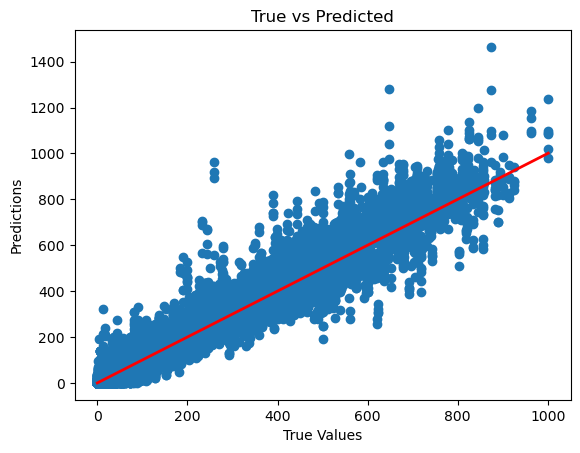

In [9]:
#Comparison between total_booked_cancellation_prediction and target_demanded

rmse_actual_ = root_mean_squared_error(y_test_actual, X_test_actual)
mae_actual_ =  mean_absolute_error(y_test_actual, X_test_actual)
r2_actual_ = r2_score(y_test_actual, X_test_actual)

print(f"Root Mean Squared Error: {rmse_actual_}")
print(f"Mean Absolute Error: {mae_actual_}")
print(f"R-squared: {r2_actual_}")

plt.scatter(y_test_actual, X_test_actual)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.show()